# Reconhecimento de Imagens usando Tensorflow

## Exemplo reconhecimento  de espécies de flores

Um dos problemas clássicos de Aprendizado Profundo (Deep Learning) usando Redes Neurais Convolucionais (CNNs) é a identificação de flores. A partir de uma base com 4500 imagens JPEG de 5 espécies de flores com cores, tamanhos e ângulos diferentes podemos identificar a qual espécie uma foto de flor qualquer pode ser classificada.   

Este exemplo mostra uma forma usual de organização de classificação de imagens. As imagens já classificadas são colocadas em diretórios diferentes com o nome da espécie. O programa inicialmente lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação igual ao nome do diretório. Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

A base de dados é separada em base de treinamento e base de teste. A rede é treinada com a base de treinamento e a base de testes avalia a acurácia de cada modelo utilizado e o tempo de treinamento é medido.

O primeiro modelo é o simples, com poucas camadas. O segundo é o modelo complexo com 18 camadas. Depois usaremos redes pré-treinadas. A técnica chamada aprendizagem de transferência, onde uma rede pré-treinada (treinada com cerca de um milhão de imagens genericas), é usada para extrair atributos e treinar uma nova camada no topo para classificar as imagens de flores.

No final é apresentado uma tabela comparando a acurácia e tempo de processamento do treinamento de cada modelo.

In [1]:
# Load libs
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib
from time import perf_counter

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.4.1'

In [2]:
# Set main images directory
data_repo = "/data/dataset/flower_photos/"

TRAIN_SAMPLE = 0.9
TEST_SAMPLE = 0.1
BATCH_SIZE = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=30

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

/data/dataset/flower_photos


## Bibliotecas úteis

In [3]:
# Some usefull libs to read and prepare images

# Get flower name base on directory
def get_label(file_path):
    # Get directory name,, i.e., flower specie 
    parts = tf.strings.split(file_path, '/')
    # Check file path and return label
    return parts[-2] == CLASS_NAMES

# Convert and resize images
def decode_img(img):
    # Decode jpeg image
    img = tf.image.decode_jpeg(img, channels=3) #color images
    # Convert unit8 tensor to floats in the [0,1]range
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # Resize the image  
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

# Image Augmentation
def augment(image, label):
    img = tf.image.rot90(image)
    img = tf.image.flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return (img, label)

# Join images and labels
def process_path(file_path):
    # Get label
    label = get_label(file_path)
    # Get image file and convert to tensor
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return (img, label)
    
# Prepare images for trining (check if it is on cache)
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # Test if images are on cache and use it
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Print some flowers
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

# Image Augumentation

In [4]:
# Create Augmentation model
image_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])



## Leitura images do repositorio

In [5]:
# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  4510


In [6]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['dandelion' 'daisy' 'sunflower' 'rose' 'tulip']


In [7]:
# Process images

#Set start time for prepare images
start_time = perf_counter()

# Read all images files and set Tensor
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/data/dataset/flower_photos/dandelion/3512879565_88dd8fc269_n.jpg'
b'/data/dataset/flower_photos/tulip/3476945045_97ff41e8ec_n.jpg'
b'/data/dataset/flower_photos/rose/27619697563_228f5c4677_n.jpg'
b'/data/dataset/flower_photos/dandelion/5045509402_6e052ce443.jpg'
b'/data/dataset/flower_photos/sunflower/34312487015_66a635fd71_n.jpg'


In [8]:

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
images_ds = prepare_for_training(labeled_ds)

# Split train and test sample
train_ds = images_ds.take(int(TRAIN_SAMPLE*SIZE_OF_DATASET))
test_ds = images_ds.skip(int(TEST_SAMPLE*SIZE_OF_DATASET))

train_images, train_labels = next(iter(train_ds))
test_images, test_labels = next(iter(test_ds))

print("train image: ", tf.size(train_images))
print("train labels: ", tf.size(train_labels))

time_ip = perf_counter() - start_time
tf.print("Image processing time: ", time_ip, "s")

train image:  tf.Tensor(7526400, shape=(), dtype=int32)
train labels:  tf.Tensor(250, shape=(), dtype=int32)
Image processing time:  5.968430572014768 s


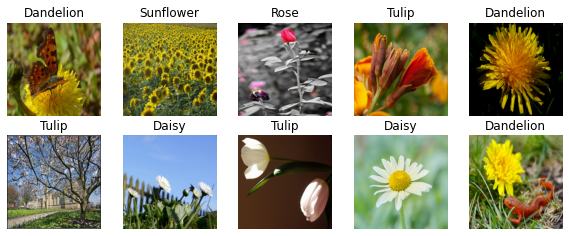

In [9]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Create Convolutional Neural Network (CNN) Model

## Simple Model

In [10]:
start_time = perf_counter()

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
], name = 'Simple_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)            

In [11]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 1.6050 - accuracy: 0.1600 - val_loss: 3.8403 - val_accuracy: 0.1800
Epoch 2/30
1/1 [==============================] - 1s 624ms/step - loss: 2.9740 - accuracy: 0.2200 - val_loss: 1.6264 - val_accuracy: 0.1800
Epoch 3/30
1/1 [==============================] - 1s 641ms/step - loss: 1.5215 - accuracy: 0.2200 - val_loss: 1.6094 - val_accuracy: 0.2400
Epoch 4/30
1/1 [==============================] - 1s 651ms/step - loss: 1.6083 - accuracy: 0.3800 - val_loss: 1.6093 - val_accuracy: 0.2400
Epoch 5/30
1/1 [==============================] - 1s 659ms/step - loss: 1.6080 - accuracy: 0.3800 - val_loss: 1.6093 - val_accuracy: 0.2400
Epoch 6/30
1/1 [==============================] - 1s 612ms/step - loss: 1.6076 - accuracy: 0.3800 - val_loss: 1.6093 - val_accuracy: 0.2400
Epoch 7/30
1/1 [==============================] - 1s 630ms/step - loss: 1.6071 - accuracy: 0.3800 - val_loss: 1.6109 - val_accuracy: 0.1800
Epoch 8/30
1/1 [=======

### Evaluating the Simple CNN Model Performance

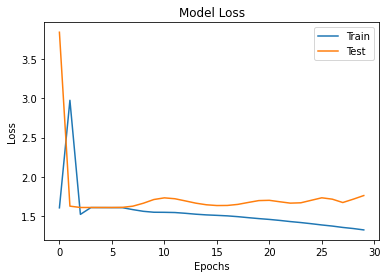

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

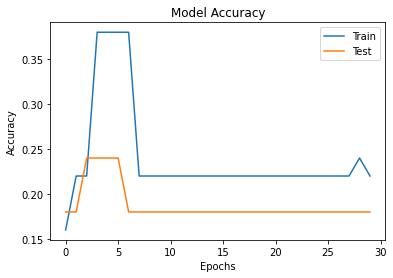

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [14]:
train_loss_sm, train_acc_sm = model.evaluate(train_images, train_labels, batch_size=BATCH_SIZE)
test_loss_sm, test_acc_sm = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
time_sm = perf_counter() - start_time
print(time_sm)

1/1 [==============================] - 0s 107ms/step - loss: 1.7614 - accuracy: 0.1800
21.639124264998827


## Complex Model 

In [15]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
], name = 'Complex_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Complex_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)      

In [16]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.6052 - accuracy: 0.2600 - val_loss: 4.4864 - val_accuracy: 0.2400
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 5.1416 - accuracy: 0.3600 - val_loss: 2.1741 - val_accuracy: 0.1800
Epoch 3/30
1/1 [==============================] - 4s 4s/step - loss: 3.4999 - accuracy: 0.2400 - val_loss: 1.6098 - val_accuracy: 0.2400
Epoch 4/30
1/1 [==============================] - 4s 4s/step - loss: 1.7018 - accuracy: 0.2400 - val_loss: 1.6071 - val_accuracy: 0.1800
Epoch 5/30
1/1 [==============================] - 4s 4s/step - loss: 1.5974 - accuracy: 0.2200 - val_loss: 1.6090 - val_accuracy: 0.3200
Epoch 6/30
1/1 [==============================] - 4s 4s/step - loss: 1.5829 - accuracy: 0.2600 - val_loss: 1.6107 - val_accuracy: 0.2400
Epoch 7/30
1/1 [==============================] - 4s 4s/step - loss: 1.5353 - accuracy: 0.3600 - val_loss: 1.6367 - val_accuracy: 0.2400
Epoch 8/30
1/1 [=========================

### Evaluating the Complex CNN Model Performance

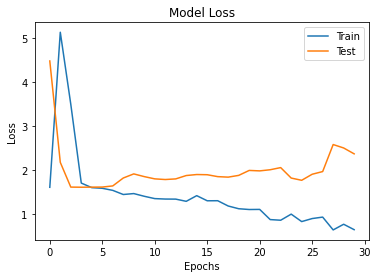

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

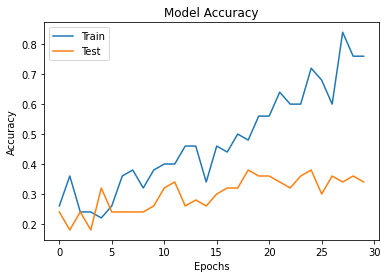

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [19]:
train_loss_cm, train_acc_cm = model.evaluate(train_images, train_labels, batch_size=BATCH_SIZE)
test_loss_cm, test_acc_cm = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
time_cm = perf_counter() - start_time
print(time_cm)

1/1 [==============================] - 0s 417ms/step - loss: 2.3681 - accuracy: 0.3400
110.28132650500629


## Transfer Learning: VGG19 Pre-trained Model

In [20]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
], name = 'VGG19_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "VGG19_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [21]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 2.3069 - accuracy: 0.1000 - val_loss: 4.1517 - val_accuracy: 0.2400
Epoch 2/30
1/1 [==============================] - 6s 6s/step - loss: 1.8531 - accuracy: 0.4400 - val_loss: 2.3249 - val_accuracy: 0.2200
Epoch 3/30
1/1 [==============================] - 6s 6s/step - loss: 1.4340 - accuracy: 0.5200 - val_loss: 1.8238 - val_accuracy: 0.2800
Epoch 4/30
1/1 [==============================] - 6s 6s/step - loss: 1.1025 - accuracy: 0.6000 - val_loss: 2.1700 - val_accuracy: 0.2400
Epoch 5/30
1/1 [==============================] - 6s 6s/step - loss: 0.7030 - accuracy: 0.7000 - val_loss: 2.1146 - val_accuracy: 0.3800
Epoch 6/30
1/1 [==============================] - 6s 6s/step - loss: 0.3510 - accuracy: 0.9000 - val_loss: 2.5495 - val_accuracy: 0.3600
Epoch 7/30
1/1 [==============================] - 6s 6s/step - loss: 0.1711 - accuracy: 0.9400 - val_loss: 2.8774 - val_accuracy: 0.4600
Epoch 8/30
1/1 [=========================

### Evaluating the VGG19 CNN Model Performance

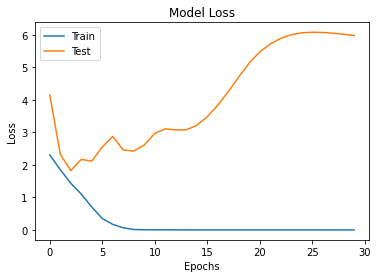

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

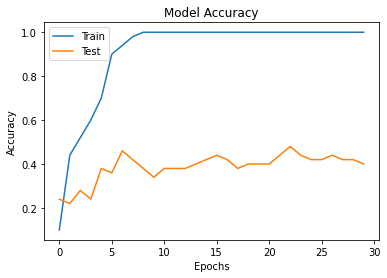

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [24]:
train_loss_vg, train_acc_vg = model.evaluate(train_images, train_labels, batch_size=BATCH_SIZE)
test_loss_vg, test_acc_vg = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
time_vg = perf_counter() - start_time
print(time_vg)

1/1 [==============================] - 3s 3s/step - loss: 5.9795 - accuracy: 0.4000
177.19347982102772


## Transfer Learning: ResNet50 Pre-trained Model

In [25]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'ResNet50_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "ResNet50_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 25,691,013
Trainable params: 2,103,301
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 1.9791 - accuracy: 0.0400 - val_loss: 2.5832 - val_accuracy: 0.2400
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 1.6388 - accuracy: 0.3800 - val_loss: 3.2441 - val_accuracy: 0.1800
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 1.9916 - accuracy: 0.2400 - val_loss: 3.1116 - val_accuracy: 0.1800
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 1.6973 - accuracy: 0.2200 - val_loss: 3.1516 - val_accuracy: 0.2800
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 1.6751 - accuracy: 0.4200 - val_loss: 3.0776 - val_accuracy: 0.2800
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 1.6729 - accuracy: 0.4000 - val_loss: 2.9850 - val_accuracy: 0.3000
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 1.6795 - accuracy: 0.4600 - val_loss: 2.9006 - val_accuracy: 0.3400
Epoch 8/30
1/1 [=========================

### Evaluating the Resnet CNN Model Performance

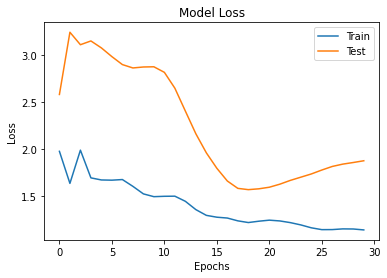

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

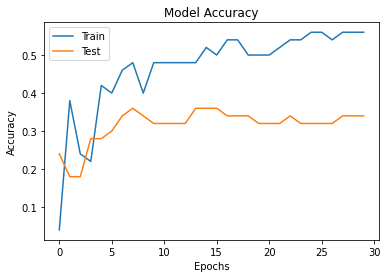

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [29]:
train_loss_rn, train_acc_rn = model.evaluate(train_images, train_labels, batch_size=BATCH_SIZE)
test_loss_rn, test_acc_rn = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
time_rn = perf_counter() - start_time
print(time_rn)

1/1 [==============================] - 1s 1s/step - loss: 1.8791 - accuracy: 0.3400
77.75235909404


## Transfer Learning: InceptionV3 Pre-trained Model 

In [30]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'InceptionV3_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "InceptionV3_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 21,821,221
Trainable params: 14,341
Non-trainable params: 21,806,880
_________________________________________________________________


In [31]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 1.9298 - accuracy: 0.2400 - val_loss: 1.6450 - val_accuracy: 0.2800
Epoch 2/30
1/1 [==============================] - 1s 986ms/step - loss: 1.3067 - accuracy: 0.4400 - val_loss: 1.5380 - val_accuracy: 0.3000
Epoch 3/30
1/1 [==============================] - 1s 964ms/step - loss: 0.8607 - accuracy: 0.7400 - val_loss: 1.4513 - val_accuracy: 0.3200
Epoch 4/30
1/1 [==============================] - 1s 960ms/step - loss: 0.5658 - accuracy: 0.8800 - val_loss: 1.3854 - val_accuracy: 0.3800
Epoch 5/30
1/1 [==============================] - 1s 981ms/step - loss: 0.3764 - accuracy: 0.9400 - val_loss: 1.3368 - val_accuracy: 0.3800
Epoch 6/30
1/1 [==============================] - 1s 988ms/step - loss: 0.2548 - accuracy: 0.9400 - val_loss: 1.3001 - val_accuracy: 0.4000
Epoch 7/30
1/1 [==============================] - 1s 985ms/step - loss: 0.1752 - accuracy: 0.9800 - val_loss: 1.2707 - val_accuracy: 0.4200
Epoch 8/30
1/1 [=======

### Evaluating the InceptionV3 CNN Model Performance

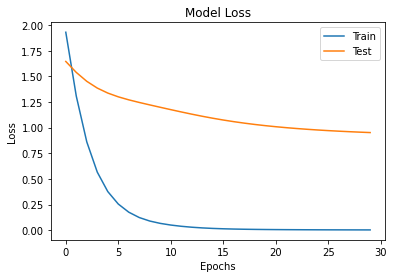

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

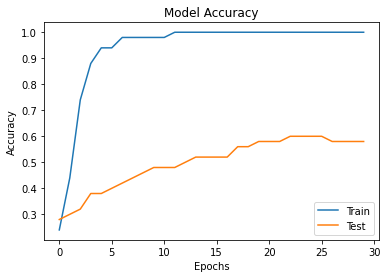

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [34]:
#train_loss_iv, train_acc_iv 
train_loss_iv, train_acc_iv = model.evaluate(train_images, train_labels, batch_size=BATCH_SIZE)
test_loss_iv, test_acc_iv = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
time_iv = perf_counter() - start_time
print(time_iv)

1/1 [==============================] - 0s 484ms/step - loss: 0.9516 - accuracy: 0.5800
36.99226013396401


## Sumary  

In [35]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",TRAIN_SAMPLE*100,"%  Test sample = ",TEST_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  4510    Train sample =  90.0 %  Test sample =  10.0 %
   Image size: (224,224)   Batch size = 50         Epochs = 30        

Processing images:                                          time = 6.0 s
Simple Model:         train_acc = 0.22    test_acc = 0.18   time = 21.6 s
Complex Model:        train_acc = 0.86    test_acc = 0.34   time = 110.3 s
VGG19:                train_acc = 1.00    test_acc = 0.40   time = 177.2 s
ResNet50:             train_acc = 0.60    test_acc = 0.34   time = 77.8 s
InceptionV3:          train_acc = 1.00    test_acc = 0.58   time = 37.0 s
